In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


**Generator**

In [9]:
import sys
import numpy as np
from keras.layers import Dense, Reshape, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

# Fix 1: Change the block size to 28 * 28 * 1 at the last layer, since the output shape is (28, 28, 1).
block_size = 128
num_blocks=4
OPTMIZER = Adam(lr=0.0002)

generator = Sequential()
generator.add(Dense(block_size, input_shape=(100, )))
generator.add(LeakyReLU(alpha=0.02))
generator.add(BatchNormalization(momentum=0.8))

for i in range(num_blocks-1):
    block_size = block_size * 2
    generator.add(Dense(block_size))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(28 * 28 * 1, activation='tanh'))
generator.add(Reshape((28, 28, 1)))
generator.compile(loss="binary_crossentropy", optimizer=OPTMIZER)


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

**Discriminator**

In [16]:
import sys
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

SHAPE =  (28, 28, 1)
CAPACITY = 28 * 28 * 1
OPTMIZER = Adam(learning_rate=0.0002)

discriminator = Sequential()
discriminator.add(Flatten(input_shape = SHAPE))
discriminator.add(Dense(CAPACITY, input_shape=SHAPE))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(int(CAPACITY/2)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss="binary_crossentropy", optimizer=OPTMIZER)

In [17]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 784)               615440    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 392)               307720    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 392)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 393       
                                                                 
Total params: 923553 (3.52 MB)
Trainable params: 92355

**GAN**

In [18]:
OPTIMIZER = Adam(learning_rate = 0.0002)
discriminator.trainable = False

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = "binary_crossentropy", optimizer = OPTIMIZER)

In [19]:
gan.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1514128   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 923553    
                                                                 
Total params: 2437681 (9.30 MB)
Trainable params: 1510288 (5.76 MB)
Non-trainable params: 927393 (3.54 MB)
_________________________________________________________________


**Load MNIST**

In [20]:
model_type = -1
def load_MNIST(model_type):

    allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]

    if model_type not in allowed_types:
        print('ERROR: Only Integer Values from -1 to 9 are allowed')

    (X_train, Y_train), (_, _) = mnist.load_data()

    xxx = X_train
#     print("X_train: ", X_train.shape)
    if model_type!=-1:
        X_train = X_train[np.where(Y_train==int(model_type)) [0]]
        print("X_train: ", X_train.shape)

    X_train = ( np.float32(X_train) - 127.5) / 127.5
#     X_train = np.expand_dims(X_train, axis=3)

    return X_train, Y_train, xxx

In [21]:
X_train , Y_train, xxx = load_MNIST(model_type = 3)

11490434/11490434 [==============================] - 1s 0us/step
X_train:  (6131, 28, 28)


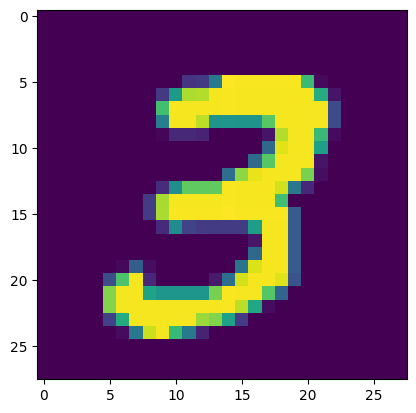

In [22]:
img = plt.imshow(X_train[0])


**Grab a batch**

In [24]:
from random import randint

# Grab a batch
count_real_images = int(32/2)
starting_index = randint(0, (len(X_train) - count_real_images ))
starting_index

5586

In [25]:
real_images_raw = X_train[starting_index: (starting_index + count_real_images)]
real_images_raw.shape

(16, 28, 28)

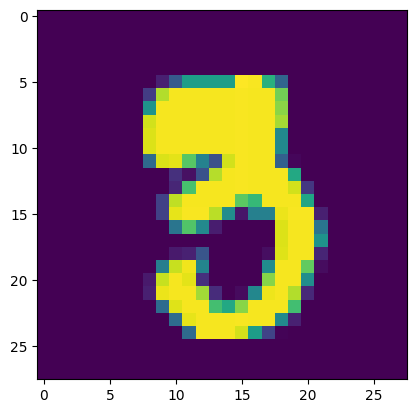

In [26]:
img = plt.imshow(real_images_raw[0])

In [27]:
x_real_images = real_images_raw.reshape(count_real_images, 28, 28, 1)
x_real_images.shape

(16, 28, 28, 1)

In [37]:
y_real_labels = np.ones([count_real_images, 1])
y_real_labels.shape

(16, 1)


**Grab Generated Images for this training batch**

In [30]:
LATENT_SPACE_SIZE = 100
def sample_latent_space(instances):
        return np.random.normal(0, 1, (instances, LATENT_SPACE_SIZE))

In [31]:
# Grab Generated Images for this training batch
latent_space_sample = sample_latent_space(count_real_images)
latent_space_sample.shape

(16, 100)

In [32]:
x_generated_images = generator.predict(latent_space_sample)

1/1 [==============================] - 4s 4s/step


In [33]:
y_generated_labels = np.zeros([32 - count_real_images, 1])
y_generated_labels.shape

(16, 1)

In [34]:
print(y_generated_labels[0], y_real_labels[0])


[0.] [1.]


In [38]:
# Combine to train on the discriminator
x_batch = np.concatenate( [x_real_images, x_generated_images] )
y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

In [39]:
x_batch.shape

(32, 28, 28, 1)

In [40]:
y_batch[16]

array([0.])


**Train Adversarial Net**


In [41]:
# Now, train the discriminator with this batch
discriminator_loss = discriminator.train_on_batch(x_batch, y_batch)
print("ok")

ok


In [42]:
# Generate Noise
x_latent_space_samples = sample_latent_space(32)
y_generated_labels = np.ones([32, 1])
y_generated_labels.shape

(32, 1)

In [43]:
generator_loss = gan.train_on_batch(x_latent_space_samples, y_generated_labels)

In [44]:
print ('Epoch: '+str(int(1))+', [Discriminator :: Loss:'+str(discriminator_loss)+'], [ Generator :: Loss:'+str(generator_loss)+']')

Epoch: 1, [Discriminator :: Loss:0.7912307381629944], [ Generator :: Loss:0.5963853597640991]
